In [1]:
######################### Q1 (MLP on Grayscale CIFAR-10) #########################

In [2]:
import os                                  
import math                                
import random
import time                             
import numpy as np                        
import torch                               # dl framework (allowed)
import torch.nn as nn                      # neural network modules
import torch.optim as optim                # optimizers
from torch.utils.data import DataLoader    # minibatch loading
from torch.utils.data import random_split  # train/val splitting
from torchvision import datasets           # CIFAR-10 dataset loader
from torchvision import transforms         # image transforms
import matplotlib.pyplot as plt            # plotting learning curves

In [3]:
SEED = 42                                  # fixed seed for repeatable results
random.seed(SEED)                          # python RNG seed
np.random.seed(SEED)                       # numpy RNG seed
torch.manual_seed(SEED)                    # torch CPU seed
torch.cuda.manual_seed_all(SEED)           # torch GPU seed (if available)
torch.backends.cudnn.deterministic = True  # determinism (may slow a bit)
torch.backends.cudnn.benchmark = False     # determinism

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = (device.type == "cuda")
print("Using device:", device)

Using device: cpu


In [5]:
# Hyperparameters and constants
BATCH_SIZE = 256                 # bigger batch = faster on CPU too (usually fine)
EPOCHS = 20                      
LR = 1e-3                        # Adam için iyi başlangıç
WEIGHT_DECAY = 1e-3              # hafif L2
DROPOUT_P = 0.25                 # 0.30 -> 0.10 (underfit azalır)
TRAIN_RATIO = 0.90               # 45k train / 5k val
PATIENCE = 5                     # early stopping sabrı (val iyileşmezse dur)                  # CIFAR-10 has 10 classes 


In [6]:
# Simple baseline normalization values for grayscale images:
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # RGB -> Gray
    transforms.ToTensor(),                        # [0,1], shape (1,32,32)
])

data_root = "./data"
train_full_raw = datasets.CIFAR10(root=data_root, train=True, download=True, transform=base_transform)
test_raw       = datasets.CIFAR10(root=data_root, train=False, download=True, transform=base_transform)


100.0%


In [7]:
n_total = len(train_full_raw)                      # 50,000
n_train = int(TRAIN_RATIO * n_total)               # 45,000
n_val   = n_total - n_train                        # 5,000

train_raw, val_raw = random_split(
    train_full_raw,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Train size: {len(train_raw)}, Val size: {len(val_raw)}, Test size: {len(test_raw)}")

Train size: 45000, Val size: 5000, Test size: 10000


In [8]:
# Compute mean/std from TRAIN ONLY (grayscale)-
def compute_mean_std_gray(dataset, batch_size=512):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    n_pixels = 0
    sum_ = 0.0
    sum_sq = 0.0
    for x, _ in loader:
        # x shape: (B,1,32,32)
        b = x.size(0)
        x = x.view(b, -1)                    # (B,1024)
        sum_ += x.sum().item()               # tüm piksellerin toplamı
        sum_sq += (x * x).sum().item()       # kareler toplamı
        n_pixels += x.numel()                # toplam piksel sayısı
    mean = sum_ / n_pixels
    var = (sum_sq / n_pixels) - (mean * mean)
    std = (var ** 0.5) if var > 0 else 1.0
    return mean, std

gray_mean, gray_std = compute_mean_std_gray(train_raw)
print(f"Computed Gray Mean: {gray_mean:.6f}, Gray Std: {gray_std:.6f}")


Computed Gray Mean: 0.481058, Gray Std: 0.239243


In [9]:
# Create final normalized datasets
norm_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((gray_mean,), (gray_std,)),  # gerçek mean/std
])

# random_split Subset döndürür; asıl dataset objesinin transform'unu değiştirebiliriz:
train_raw.dataset.transform = norm_transform
val_raw.dataset.transform   = norm_transform
test_raw.transform          = norm_transform


In [10]:
# If we have GPU available, pin_memory should be True.
pin = use_cuda

# persistent_workers sadece num_workers>0 ise kullanılabilir.
# Windows'ta epoch arası worker restart maliyetini azaltır.
num_workers = 2  # stabil ise 2 iyi, sorun çıkarsa 0'a çekebilirsin
persist = (num_workers > 0)

train_loader = DataLoader(
    train_raw, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persist
)
val_loader = DataLoader(
    val_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persist
)
test_loader = DataLoader(
    test_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persist
)

In [11]:
# A Class for MLP Feedforward Neural Network)
class MLP(nn.Module):
    def __init__(self, dropout_p=0.1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(32*32, 1024),     # daha geniş ilk katman
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, num_classes) # logits
        )

    def forward(self, x):
        # x: (B,1,32,32) -> flatten
        x = x.view(x.size(0), -1)
        return self.net(x)

model = MLP(dropout_p=DROPOUT_P, num_classes=10).to(device)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [12]:
# Loss function + Optimizer + Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Val loss durursa LR düşür (çok işe yarar)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2)



In [13]:
# Utility: Accuracy computation
def accuracy_from_logits(logits, y):
    pred = torch.argmax(logits, dim=1)
    return (pred == y).float().mean().item()

In [14]:
# 11) Training + Validation loops
# ----------------------------
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total_acc  = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)  # GPU varsa hız
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

In [15]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc  = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

In [16]:
#Training loop + Best checkpoint + Early stopping
# ----------------------------
best_val_acc = -1.0
best_path = "best_mlp_cifar10_gray.pt"

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
no_improve = 0  # early stopping counter

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc     = evaluate(model, val_loader)

    # LR scheduler val_loss ile çalışır
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}% | "
        f"Epoch sec: {time.time() - t0:.1f}s"
    )

    # Best checkpoint by val accuracy
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        no_improve = 0
        print(f"  -> Saved best (val acc = {best_val_acc*100:.2f}%)")
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f"Early stopping: no val acc improvement for {PATIENCE} epochs.")
        break

print("Training finished. Best Val Acc:", best_val_acc)

Epoch 01/20 | Train Loss: 1.9473, Train Acc: 30.00% | Val Loss: 1.8417, Val Acc: 34.76% | Epoch sec: 33.2s
  -> Saved best (val acc = 34.76%)
Epoch 02/20 | Train Loss: 1.8079, Train Acc: 35.86% | Val Loss: 1.7372, Val Acc: 38.90% | Epoch sec: 7.0s
  -> Saved best (val acc = 38.90%)
Epoch 03/20 | Train Loss: 1.7504, Train Acc: 38.38% | Val Loss: 1.7595, Val Acc: 39.04% | Epoch sec: 7.4s
  -> Saved best (val acc = 39.04%)
Epoch 04/20 | Train Loss: 1.7072, Train Acc: 39.72% | Val Loss: 1.6994, Val Acc: 40.42% | Epoch sec: 7.1s
  -> Saved best (val acc = 40.42%)
Epoch 05/20 | Train Loss: 1.6661, Train Acc: 41.38% | Val Loss: 1.6724, Val Acc: 41.24% | Epoch sec: 7.0s
  -> Saved best (val acc = 41.24%)
Epoch 06/20 | Train Loss: 1.6458, Train Acc: 41.90% | Val Loss: 1.6406, Val Acc: 42.02% | Epoch sec: 7.3s
  -> Saved best (val acc = 42.02%)
Epoch 07/20 | Train Loss: 1.6251, Train Acc: 42.42% | Val Loss: 1.6338, Val Acc: 42.62% | Epoch sec: 7.1s
  -> Saved best (val acc = 42.62%)
Epoch 08/20 

In [17]:
# Test with best model
best_model = MLP(dropout_p=DROPOUT_P, num_classes=10).to(device)
best_model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(best_model, test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")

Test Loss: 1.5014 | Test Accuracy: 47.12%


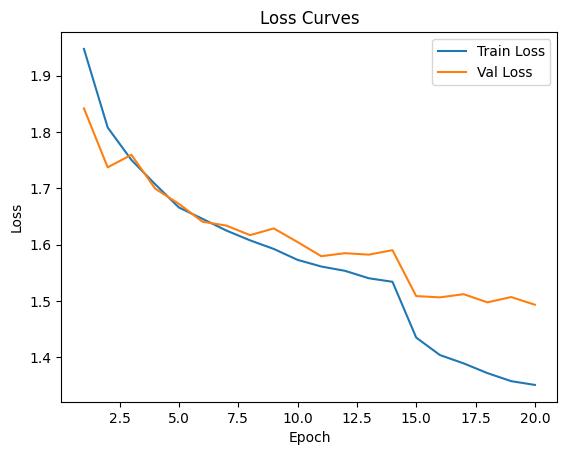

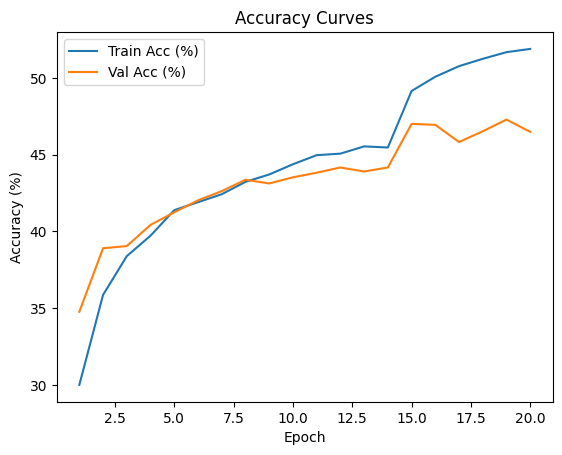

In [18]:
# Plots
epochs_axis = np.arange(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_axis, history["train_loss"], label="Train Loss")
plt.plot(epochs_axis, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs_axis, np.array(history["train_acc"]) * 100, label="Train Acc (%)")
plt.plot(epochs_axis, np.array(history["val_acc"]) * 100, label="Val Acc (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy Curves"); plt.legend(); plt.show()